## 1. Setup & Load Data

In [175]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Paths
project_root = Path.cwd().parent
data_path = project_root / 'data' / 'processed'
features_path = project_root / 'data' / 'features'
eval_path = project_root / 'data' / 'evaluation'
eval_path.mkdir(parents=True, exist_ok=True)

print("Loading datasets...")

# Load all data
devices = pd.read_csv(data_path / 'devices.csv', dtype={'deviceid': str})
events = pd.read_csv(data_path / 'events.csv', dtype={'deviceId': str, 'hashId': str})
training_content = pd.read_csv(data_path / 'training_content.csv', dtype={'hashid': str})
testing_content = pd.read_csv(data_path / 'testing_content.csv', dtype={'hashid': str})

print(f"✓ Devices: {len(devices):,}")
print(f"✓ Events: {len(events):,}")
print(f"✓ Training articles: {len(training_content):,}")
print(f"✓ Testing articles: {len(testing_content):,}")
print(f"✓ Active users: {events['deviceId'].nunique():,}")

Loading datasets...
✓ Devices: 10,400
✓ Events: 3,544,161
✓ Training articles: 8,170
✓ Testing articles: 970
✓ Active users: 8,977


## 2. Create Train-Validation Split (80-20)

In [176]:
print("Creating 80-20 temporal split per user...")
start_time = time.time()

# Sort by timestamp
events_sorted = events.sort_values(['deviceId', 'eventTimestamp']).copy()

# Split per user
train_events = []
val_events = []
train_ground_truth = defaultdict(set)
val_ground_truth = defaultdict(set)

for user_id, group in events_sorted.groupby('deviceId'):
    events_list = group[['deviceId', 'hashId', 'event_type', 'eventTimestamp']].values
    n_events = len(events_list)
    
    # 80-20 split
    split_idx = int(n_events * 0.8)
    
    # Training events (first 80%)
    train_portion = events_list[:split_idx]
    train_events.extend(train_portion)
    for event in train_portion:
        train_ground_truth[event[0]].add(event[1])  # deviceId -> hashId
    
    # Validation events (last 20%)
    val_portion = events_list[split_idx:]
    val_events.extend(val_portion)
    for event in val_portion:
        val_ground_truth[event[0]].add(event[1])  # deviceId -> hashId

# Convert to DataFrames
train_df = pd.DataFrame(train_events, columns=['deviceId', 'hashId', 'event_type', 'eventTimestamp'])
val_df = pd.DataFrame(val_events, columns=['deviceId', 'hashId', 'event_type', 'eventTimestamp'])

print(f"\n{'='*70}")
print(f"✓ Split completed in {time.time() - start_time:.2f}s")
print(f"{'='*70}")
print(f"\nSplit Statistics:")
print(f"  Training events: {len(train_df):,} ({len(train_df)/len(events)*100:.1f}%)")
print(f"  Validation events: {len(val_df):,} ({len(val_df)/len(events)*100:.1f}%)")
print(f"  \nUsers in training: {len(train_ground_truth):,}")
print(f"  Users in validation: {len(val_ground_truth):,}")
print(f"  \nUnique articles in training: {train_df['hashId'].nunique():,}")
print(f"  Unique articles in validation: {val_df['hashId'].nunique():,}")
print(f"  \nAvg articles per user (train): {train_df.groupby('deviceId').size().mean():.1f}")
print(f"  Avg articles per user (val): {val_df.groupby('deviceId').size().mean():.1f}")

# Save splits
train_df.to_csv(data_path / 'train_split.csv', index=False)
val_df.to_csv(data_path / 'val_split.csv', index=False)
print(f"\n✓ Saved splits to {data_path}/")

Creating 80-20 temporal split per user...

✓ Split completed in 6.80s

Split Statistics:
  Training events: 2,831,554 (79.9%)
  Validation events: 712,607 (20.1%)
  
Users in training: 8,560
  Users in validation: 8,977
  
Unique articles in training: 14,186
  Unique articles in validation: 9,443
  
Avg articles per user (train): 330.8
  Avg articles per user (val): 79.4

✓ Saved splits to /Users/deepakkumarsingh/Desktop/Inshorts/assignment/data/processed/


## 3. Load Pre-Computed Features

In [177]:
print("Loading pre-computed features...")

# Load user profiles and article features
user_profiles = pd.read_csv(features_path / 'user_profiles.csv', dtype={'deviceId': str})
article_features = pd.read_csv(features_path / 'article_features.csv', dtype={'hashid': str})

# Load pickled features
with open(features_path / 'user_similarity.pkl', 'rb') as f:
    user_similarity_dict = pickle.load(f)

with open(features_path / 'interaction_matrix.pkl', 'rb') as f:
    interaction_matrix = pickle.load(f)

with open(features_path / 'mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
    user_to_idx = mappings['user_to_idx']
    idx_to_user = mappings['idx_to_user']
    article_to_idx = mappings['article_to_idx']
    idx_to_article = mappings['idx_to_article']

with open(features_path / 'user_category_tfidf.pkl', 'rb') as f:
    user_category_tfidf = pickle.load(f)

with open(features_path / 'training_tfidf.pkl', 'rb') as f:
    training_tfidf = pickle.load(f)

print(f"\n{'='*70}")
print("FEATURE INVENTORY")
print(f"{'='*70}")
print(f"✓ User profiles: {len(user_profiles):,} users")
print(f"✓ Article features: {len(article_features):,} articles")
print(f"✓ User similarity: {len(user_similarity_dict):,} users with neighbors")
print(f"✓ Interaction matrix: {interaction_matrix.shape}")
print(f"✓ User TF-IDF: {user_category_tfidf.shape}")
print(f"✓ Training TF-IDF: {training_tfidf.shape}")

# Filter to training articles only (for Stage 1 & 2)
# CRITICAL: Use is_test flag to preserve order matching training_tfidf.pkl
article_features_train = article_features[article_features['is_test'] == 0].copy()
print(f"\n✓ Filtered to {len(article_features_train):,} training articles for evaluation")
print(f"  (Order matches training_tfidf.pkl for correct similarity alignment)")

Loading pre-computed features...

FEATURE INVENTORY
✓ User profiles: 8,689 users
✓ Article features: 9,140 articles
✓ User similarity: 8,560 users with neighbors
✓ Interaction matrix: (8560, 14187)
✓ User TF-IDF: (8689, 31)
✓ Training TF-IDF: (8170, 31)

✓ Filtered to 8,170 training articles for evaluation
  (Order matches training_tfidf.pkl for correct similarity alignment)


## 4. Content-Based Recommender (Vectorized)

In [178]:
class VectorizedContentBasedRecommender:
    """
    Vectorized Content-Based Filtering
    
    Weights:
    - Category Similarity: 50%
    - Popularity: 15%
    - Language Match: 15%
    - Type Preference: 10%
    - Geographic: 10%
    """
    
    def __init__(self, user_profiles_df, article_features_df, user_tfidf, article_tfidf, popularity_dict):
        self.user_profiles = user_profiles_df.set_index('deviceId')
        self.article_features = article_features_df.set_index('hashid')
        self.user_tfidf = user_tfidf
        self.article_tfidf = article_tfidf
        self.popularity_dict = popularity_dict
        
        # Precompute cosine similarity matrix (users x articles)
        print("Precomputing TF-IDF similarity matrix...")
        start = time.time()
        self.similarity_matrix = cosine_similarity(user_tfidf, article_tfidf)
        print(f"  ✓ Computed {self.similarity_matrix.shape} matrix in {time.time()-start:.2f}s")
        
        # Map user IDs to row indices
        self.user_id_to_idx = {uid: i for i, uid in enumerate(user_profiles_df['deviceId'])}
        self.article_id_to_idx = {aid: i for i, aid in enumerate(article_features_df['hashid'])}
        
        print(f"\nVectorizedContentBasedRecommender initialized")
        print(f"  Users: {len(self.user_profiles):,}")
        print(f"  Articles: {len(self.article_features):,}")
        print(f"  Similarity matrix: {self.similarity_matrix.shape}")
    
    def recommend_batch(self, user_ids, top_k=50):
        """
        Generate recommendations for a batch of users
        """
        recommendations = []
        
        for user_id in user_ids:
            if user_id not in self.user_id_to_idx:
                continue
            
            user_idx = self.user_id_to_idx[user_id]
            user_data = self.user_profiles.loc[user_id]
            
            # Get TF-IDF similarity (50% weight)
            category_sim = self.similarity_matrix[user_idx, :]
            
            # Get article data
            articles = self.article_features.copy()
            articles['category_sim'] = category_sim
            
            # Language match (15% weight)
            user_lang = user_data['final_language']
            articles['language_match'] = (articles['language'] == user_lang).astype(float)
            
            # Type preference (10% weight)
            user_type = user_data['preferred_newsType']
            articles['type_match'] = articles['newstype'].apply(
                lambda x: 1.0 if x == user_type else 0.5
            )
            
            # Popularity (15% weight)
            articles['popularity'] = articles.index.map(
                lambda x: self.popularity_dict.get(x, 0.0)
            )
            
            # Geographic (10% weight)
            user_city = user_data.get('user_city', None)
            if pd.notna(user_city) and user_city != 'UNKNOWN':
                articles['geo_score'] = articles['inferred_location'].apply(
                    lambda x: 1.0 if x == user_city else 0.3 if pd.notna(x) else 0.5
                )
            else:
                articles['geo_score'] = 0.5
            
            # Combined score
            articles['final_score'] = (
                articles['category_sim'] * 0.50 +
                articles['popularity'] * 0.15 +
                articles['language_match'] * 0.15 +
                articles['type_match'] * 0.10 +
                articles['geo_score'] * 0.10
            )
            
            # Top K recommendations
            top_articles = articles.nlargest(top_k, 'final_score')
            
            for rank, (article_id, row) in enumerate(top_articles.iterrows(), 1):
                recommendations.append({
                    'deviceId': user_id,
                    'hashId': article_id,
                    'rank': rank,
                    'score': row['final_score'],
                    'category_sim': row['category_sim'],
                    'popularity': row['popularity'],
                    'language_match': row['language_match'],
                    'type_match': row['type_match'],
                    'geo_score': row['geo_score']
                })
        
        return pd.DataFrame(recommendations)
    
    def recommend_all(self, top_k=50, batch_size=500):
        """
        Generate recommendations for all users in batches
        """
        all_user_ids = list(self.user_profiles.index)
        total_users = len(all_user_ids)
        
        print(f"\nGenerating content-based recommendations...")
        print(f"  Users: {total_users:,}")
        print(f"  Top-K: {top_k}")
        print(f"  Batch size: {batch_size}")
        
        all_recs = []
        start_time = time.time()
        
        for i in range(0, total_users, batch_size):
            batch = all_user_ids[i:i+batch_size]
            batch_recs = self.recommend_batch(batch, top_k=top_k)
            all_recs.append(batch_recs)
            
            if (i // batch_size + 1) % 5 == 0:
                elapsed = time.time() - start_time
                progress = (i + batch_size) / total_users * 100
                print(f"  Progress: {progress:.1f}% ({i+batch_size:,}/{total_users:,}) - {elapsed:.1f}s")
        
        final_recs = pd.concat(all_recs, ignore_index=True)
        total_time = time.time() - start_time
        
        print(f"\n{'='*70}")
        print(f"✓ Content-Based Generation Complete")
        print(f"{'='*70}")
        print(f"  Total time: {total_time:.2f}s")
        print(f"  Throughput: {total_users/total_time:.1f} users/sec")
        print(f"  Recommendations: {len(final_recs):,}")
        
        return final_recs

print("✓ VectorizedContentBasedRecommender class defined")

✓ VectorizedContentBasedRecommender class defined


## 5. Evaluation Metrics

In [192]:
def calculate_ndcg_at_k(recommendations, ground_truth, k=50):
    """
    Calculate NDCG@K (Normalized Discounted Cumulative Gain)
    
    Measures ranking quality with position discount
    """
    # Pre-group recommendations by user (OPTIMIZATION)
    user_recs_dict = {user_id: group['hashId'].values[:k] 
                      for user_id, group in recommendations.groupby('deviceId')}
    
    ndcg_scores = []
    
    for user_id, gt_articles in ground_truth.items():
        user_recs = user_recs_dict.get(user_id, [])
        
        if len(user_recs) == 0 or len(gt_articles) == 0:
            continue
        
        # DCG: sum of (relevance / log2(rank+1))
        dcg = 0.0
        for rank, article_id in enumerate(user_recs, 1):
            if article_id in gt_articles:
                dcg += 1.0 / np.log2(rank + 1)
        
        # IDCG: ideal DCG (all relevant items at top)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(gt_articles), k)))
        
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)
    
    return np.mean(ndcg_scores) if ndcg_scores else 0.0


def calculate_precision_at_k(recommendations, ground_truth, k=50):
    """
    Calculate Precision@K
    
    Fraction of recommended items that are relevant
    """
    # Pre-group recommendations by user (OPTIMIZATION)
    user_recs_dict = {user_id: group['hashId'].values[:k] 
                      for user_id, group in recommendations.groupby('deviceId')}
    
    precision_scores = []
    
    for user_id, gt_articles in ground_truth.items():
        user_recs = user_recs_dict.get(user_id, [])
        
        if len(user_recs) == 0:
            continue
        
        hits = sum(1 for article_id in user_recs if article_id in gt_articles)
        precision = hits / k
        precision_scores.append(precision)
    
    return np.mean(precision_scores) if precision_scores else 0.0


def calculate_recall_at_k(recommendations, ground_truth, k=50):
    """
    Calculate Recall@K
    
    Fraction of relevant items that were recommended
    """
    # Pre-group recommendations by user (OPTIMIZATION)
    user_recs_dict = {user_id: group['hashId'].values[:k] 
                      for user_id, group in recommendations.groupby('deviceId')}
    
    recall_scores = []
    
    for user_id, gt_articles in ground_truth.items():
        user_recs = user_recs_dict.get(user_id, [])
        
        if len(gt_articles) == 0:
            continue
        
        hits = sum(1 for article_id in user_recs if article_id in gt_articles)
        recall = hits / len(gt_articles)
        recall_scores.append(recall)
    
    return np.mean(recall_scores) if recall_scores else 0.0


def calculate_map_at_k(recommendations, ground_truth, k=50):
    """
    Calculate MAP@K (Mean Average Precision)
    
    Average precision at each relevant position
    """
    # Pre-group recommendations by user (OPTIMIZATION)
    user_recs_dict = {user_id: group['hashId'].values[:k] 
                      for user_id, group in recommendations.groupby('deviceId')}
    
    ap_scores = []
    
    for user_id, gt_articles in ground_truth.items():
        user_recs = user_recs_dict.get(user_id, [])
        
        if len(user_recs) == 0 or len(gt_articles) == 0:
            continue
        
        hits = 0
        precision_sum = 0.0
        
        for rank, article_id in enumerate(user_recs, 1):
            if article_id in gt_articles:
                hits += 1
                precision_sum += hits / rank
        
        ap = precision_sum / len(gt_articles) if len(gt_articles) > 0 else 0.0
        ap_scores.append(ap)
    
    return np.mean(ap_scores) if ap_scores else 0.0


def calculate_coverage(recommendations, total_articles):
    """
    Calculate Coverage
    
    Fraction of catalog that appears in recommendations
    """
    if len(recommendations) == 0:
        return 0.0
    unique_articles = recommendations['hashId'].nunique()
    return unique_articles / total_articles


def calculate_diversity(recommendations, article_features):
    """
    Calculate Diversity
    
    Distribution of categories in recommendations vs catalog
    """
    if len(recommendations) == 0:
        return 0.0
    
    # Category distribution in recommendations
    rec_articles = recommendations['hashId'].unique()
    rec_categories = article_features[article_features['hashid'].isin(rec_articles)]['categories'].value_counts(normalize=True)
    
    # Category distribution in catalog
    catalog_categories = article_features['categories'].value_counts(normalize=True)
    
    # Jensen-Shannon divergence (similarity between distributions)
    from scipy.spatial.distance import jensenshannon
    
    # Align categories
    all_categories = set(rec_categories.index) | set(catalog_categories.index)
    rec_dist = [rec_categories.get(cat, 0) for cat in all_categories]
    catalog_dist = [catalog_categories.get(cat, 0) for cat in all_categories]
    
    # Diversity = 1 - JS divergence (higher is more diverse)
    js_div = jensenshannon(rec_dist, catalog_dist)
    diversity = 1 - js_div
    
    return diversity


def calculate_novelty(recommendations, article_popularity):
    """
    Calculate Novelty
    
    Average of (1 - normalized_popularity) for recommended articles
    Higher novelty = recommending less popular (more novel) items
    """
    if len(recommendations) == 0:
        return 0.0
    
    rec_articles = recommendations['hashId'].unique()
    popularities = [article_popularity.get(aid, 0.0) for aid in rec_articles]
    
    # Novelty = 1 - avg(popularity)
    novelty = 1 - np.mean(popularities) if popularities else 0.0
    return novelty


def evaluate_recommendations(recommendations, ground_truth, article_features, article_popularity, stage_name):
    """
    Comprehensive evaluation with all 7 metrics
    """
    print(f"\n{'='*70}")
    print(f"EVALUATION: {stage_name}")
    print(f"{'='*70}")
    
    total_articles = len(article_features)
    eval_start = time.time()
    
    # Ranking quality metrics (only if ground truth available)
    if ground_truth:
        ndcg = calculate_ndcg_at_k(recommendations, ground_truth, k=50)
        precision = calculate_precision_at_k(recommendations, ground_truth, k=50)
        recall = calculate_recall_at_k(recommendations, ground_truth, k=50)
        map_score = calculate_map_at_k(recommendations, ground_truth, k=50)
        
        print(f"\nRanking Quality Metrics:")
        print(f"  NDCG@50:      {ndcg:.4f}")
        print(f"  Precision@50: {precision:.4f}")
        print(f"  Recall@50:    {recall:.4f}")
        print(f"  MAP@50:       {map_score:.4f}")
    else:
        ndcg, precision, recall, map_score = None, None, None, None
        print(f"\nRanking Quality Metrics: N/A (no ground truth)")
    
    # Catalog quality metrics
    coverage = calculate_coverage(recommendations, total_articles)
    diversity = calculate_diversity(recommendations, article_features)
    novelty = calculate_novelty(recommendations, article_popularity)
    
    print(f"\nCatalog Quality Metrics:")
    if len(recommendations) > 0:
        print(f"  Coverage:     {coverage:.4f} ({recommendations['hashId'].nunique()}/{total_articles} articles)")
    else:
        print(f"  Coverage:     {coverage:.4f} (0/{total_articles} articles - cold start)")
    print(f"  Diversity:    {diversity:.4f} (category distribution similarity)")
    print(f"  Novelty:      {novelty:.4f} (preference for non-popular items)")
    
    print(f"\n  Evaluation time: {time.time() - eval_start:.2f}s")
    
    return {
        'stage': stage_name,
        'ndcg@50': ndcg,
        'precision@50': precision,
        'recall@50': recall,
        'map@50': map_score,
        'coverage': coverage,
        'diversity': diversity,
        'novelty': novelty
    }

print("✓ Evaluation metrics defined")

✓ Evaluation metrics defined


## 6. Stage 1: Training Set Evaluation (80%)

**Ground Truth**: Articles users read in training period (80% of events)

In [180]:
# Prepare popularity dictionary (normalized)
article_popularity = {}
for article_id in article_features_train['hashid']:
    pop_score = article_features_train[article_features_train['hashid'] == article_id]['popularity'].values
    if len(pop_score) > 0:
        article_popularity[article_id] = pop_score[0]

# Initialize content-based recommender
cb_recommender = VectorizedContentBasedRecommender(
    user_profiles_df=user_profiles,
    article_features_df=article_features_train,
    user_tfidf=user_category_tfidf,
    article_tfidf=training_tfidf,
    popularity_dict=article_popularity
)

# Generate recommendations
train_recommendations = cb_recommender.recommend_all(top_k=50, batch_size=500)

# Evaluate
train_results = evaluate_recommendations(
    recommendations=train_recommendations,
    ground_truth=train_ground_truth,
    article_features=article_features_train,
    article_popularity=article_popularity,
    stage_name="Training Set (80%)"
)

# Save recommendations
train_recommendations.to_csv(eval_path / 'train_recommendations.csv', index=False)
print(f"\n✓ Saved to {eval_path}/train_recommendations.csv")

Precomputing TF-IDF similarity matrix...
  ✓ Computed (8689, 8170) matrix in 0.06s

VectorizedContentBasedRecommender initialized
  Users: 8,689
  Articles: 8,170
  Similarity matrix: (8689, 8170)

Generating content-based recommendations...
  Users: 8,689
  Top-K: 50
  Batch size: 500
  Progress: 28.8% (2,500/8,689) - 9.9s
  Progress: 57.5% (5,000/8,689) - 19.7s
  Progress: 86.3% (7,500/8,689) - 29.4s

✓ Content-Based Generation Complete
  Total time: 34.07s
  Throughput: 255.0 users/sec
  Recommendations: 434,450

EVALUATION: Training Set (80%)

Ranking Quality Metrics:
  NDCG@50:      0.2265
  Precision@50: 0.1452
  Recall@50:    0.1158
  MAP@50:       0.0432

Catalog Quality Metrics:
  Coverage:     0.1548 (1265/8170 articles)
  Diversity:    0.6984 (category distribution similarity)
  Novelty:      0.4155 (preference for non-popular items)

  Evaluation time: 0.71s

✓ Saved to /Users/deepakkumarsingh/Desktop/Inshorts/assignment/data/evaluation/train_recommendations.csv


## 7. Stage 2: Validation Set Evaluation (20%)

**Ground Truth**: Articles users read in validation period (20% of events)

In [181]:
# Use same recommender (features built on training data)
# But evaluate against validation ground truth

val_results = evaluate_recommendations(
    recommendations=train_recommendations,  # Same recommendations
    ground_truth=val_ground_truth,          # Different ground truth
    article_features=article_features_train,
    article_popularity=article_popularity,
    stage_name="Validation Set (20%)"
)

# Save validation ground truth for reference
val_gt_df = pd.DataFrame([
    {'deviceId': uid, 'hashId': aid}
    for uid, articles in val_ground_truth.items()
    for aid in articles
])
val_gt_df.to_csv(eval_path / 'validation_ground_truth.csv', index=False)
print(f"\n✓ Saved validation ground truth to {eval_path}/validation_ground_truth.csv")


EVALUATION: Validation Set (20%)

Ranking Quality Metrics:
  NDCG@50:      0.0818
  Precision@50: 0.0254
  Recall@50:    0.1017
  MAP@50:       0.0340

Catalog Quality Metrics:
  Coverage:     0.1548 (1265/8170 articles)
  Diversity:    0.6984 (category distribution similarity)
  Novelty:      0.4155 (preference for non-popular items)

  Evaluation time: 0.65s

✓ Saved validation ground truth to /Users/deepakkumarsingh/Desktop/Inshorts/assignment/data/evaluation/validation_ground_truth.csv


## 8. Stage 3: Testing Set Analysis (970 new articles)

**No Ground Truth**: Users never saw these articles

**Metrics**: Coverage & Diversity only

In [182]:
# Load testing TF-IDF
with open(features_path / 'testing_tfidf.pkl', 'rb') as f:
    testing_tfidf = pickle.load(f)

# Filter article features to testing articles
testing_article_ids = set(testing_content['hashid'])
article_features_test = article_features[article_features['hashid'].isin(testing_article_ids)].copy()

print(f"Testing articles: {len(article_features_test):,}")

# Prepare testing popularity (no historical data, use zeros)
test_article_popularity = {aid: 0.0 for aid in article_features_test['hashid']}

# Initialize content-based recommender for testing
cb_test_recommender = VectorizedContentBasedRecommender(
    user_profiles_df=user_profiles,
    article_features_df=article_features_test,
    user_tfidf=user_category_tfidf,
    article_tfidf=testing_tfidf,
    popularity_dict=test_article_popularity
)

# Generate recommendations
test_recommendations = cb_test_recommender.recommend_all(top_k=50, batch_size=500)

# Evaluate (no ground truth)
test_results = evaluate_recommendations(
    recommendations=test_recommendations,
    ground_truth=None,  # No ground truth
    article_features=article_features_test,
    article_popularity=test_article_popularity,
    stage_name="Testing Set (970 articles)"
)

# Save recommendations
test_recommendations.to_csv(eval_path / 'test_recommendations.csv', index=False)
print(f"\n✓ Saved to {eval_path}/test_recommendations.csv")

Testing articles: 970
Precomputing TF-IDF similarity matrix...
  ✓ Computed (8689, 970) matrix in 0.01s

VectorizedContentBasedRecommender initialized
  Users: 8,689
  Articles: 970
  Similarity matrix: (8689, 970)

Generating content-based recommendations...
  Users: 8,689
  Top-K: 50
  Batch size: 500
  Progress: 28.8% (2,500/8,689) - 4.5s
  Progress: 57.5% (5,000/8,689) - 8.9s
  Progress: 86.3% (7,500/8,689) - 13.4s

✓ Content-Based Generation Complete
  Total time: 15.53s
  Throughput: 559.5 users/sec
  Recommendations: 434,450

EVALUATION: Testing Set (970 articles)

Ranking Quality Metrics: N/A (no ground truth)

Catalog Quality Metrics:
  Coverage:     0.4495 (436/970 articles)
  Diversity:    0.7712 (category distribution similarity)
  Novelty:      1.0000 (preference for non-popular items)

  Evaluation time: 0.03s

✓ Saved to /Users/deepakkumarsingh/Desktop/Inshorts/assignment/data/evaluation/test_recommendations.csv


## 9. Summary Report

In [183]:
# Combine all results
results_df = pd.DataFrame([train_results, val_results, test_results])

print(f"\n{'='*70}")
print("COMPREHENSIVE EVALUATION SUMMARY")
print(f"{'='*70}")
print("\nContent-Based Filtering Performance:\n")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv(eval_path / 'evaluation_summary.csv', index=False)
print(f"\n✓ Saved summary to {eval_path}/evaluation_summary.csv")

# Key insights
print(f"\n{'='*70}")
print("KEY INSIGHTS")
print(f"{'='*70}")
print(f"\n1. Training Performance:")
print(f"   - NDCG@50: {train_results['ndcg@50']:.4f} (ranking quality)")
print(f"   - Coverage: {train_results['coverage']:.4f} (catalog utilization)")
print(f"\n2. Validation Generalization:")
print(f"   - NDCG@50: {val_results['ndcg@50']:.4f} (unseen interactions)")
print(f"   - Precision drop: {(train_results['precision@50'] - val_results['precision@50'])*100:.2f}%")
print(f"\n3. Testing Cold Start:")
print(f"   - Coverage: {test_results['coverage']:.4f} (new article recommendations)")
print(f"   - Diversity: {test_results['diversity']:.4f} (category distribution)")
print(f"   - Novelty: {test_results['novelty']:.4f} (non-popular preference)")


COMPREHENSIVE EVALUATION SUMMARY

Content-Based Filtering Performance:

                     stage  ndcg@50  precision@50  recall@50   map@50  coverage  diversity  novelty
        Training Set (80%) 0.226488      0.145157    0.11582 0.043168  0.154835   0.698360 0.415526
      Validation Set (20%) 0.081830      0.025395    0.10174 0.034003  0.154835   0.698360 0.415526
Testing Set (970 articles)      NaN           NaN        NaN      NaN  0.449485   0.771195 1.000000

✓ Saved summary to /Users/deepakkumarsingh/Desktop/Inshorts/assignment/data/evaluation/evaluation_summary.csv

KEY INSIGHTS

1. Training Performance:
   - NDCG@50: 0.2265 (ranking quality)
   - Coverage: 0.1548 (catalog utilization)

2. Validation Generalization:
   - NDCG@50: 0.0818 (unseen interactions)
   - Precision drop: 11.98%

3. Testing Cold Start:
   - Coverage: 0.4495 (new article recommendations)
   - Diversity: 0.7712 (category distribution)
   - Novelty: 1.0000 (non-popular preference)


## 10. Visualization

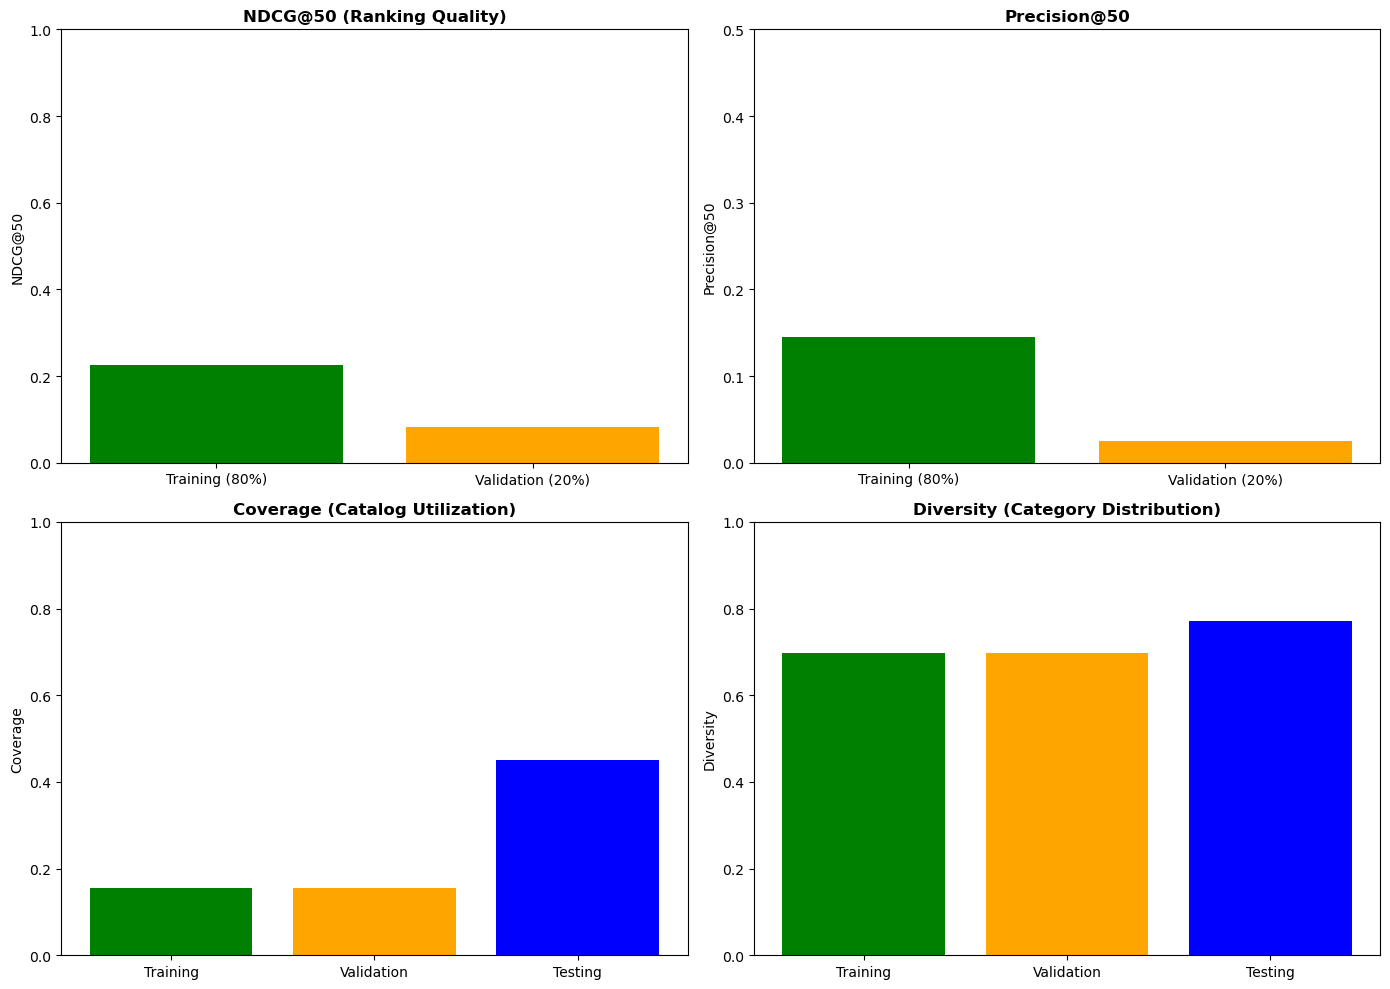


✓ Saved visualization to /Users/deepakkumarsingh/Desktop/Inshorts/assignment/data/evaluation/evaluation_metrics.png


In [184]:
import matplotlib.pyplot as plt

# Metric comparison across stages
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# NDCG comparison
stages = ['Training (80%)', 'Validation (20%)']
ndcg_values = [train_results['ndcg@50'], val_results['ndcg@50']]
axes[0, 0].bar(stages, ndcg_values, color=['green', 'orange'])
axes[0, 0].set_title('NDCG@50 (Ranking Quality)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_ylabel('NDCG@50')

# Precision comparison
precision_values = [train_results['precision@50'], val_results['precision@50']]
axes[0, 1].bar(stages, precision_values, color=['green', 'orange'])
axes[0, 1].set_title('Precision@50', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(0, 0.5)
axes[0, 1].set_ylabel('Precision@50')

# Coverage comparison
all_stages = ['Training', 'Validation', 'Testing']
coverage_values = [train_results['coverage'], val_results['coverage'], test_results['coverage']]
axes[1, 0].bar(all_stages, coverage_values, color=['green', 'orange', 'blue'])
axes[1, 0].set_title('Coverage (Catalog Utilization)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_ylabel('Coverage')

# Diversity comparison
diversity_values = [train_results['diversity'], val_results['diversity'], test_results['diversity']]
axes[1, 1].bar(all_stages, diversity_values, color=['green', 'orange', 'blue'])
axes[1, 1].set_title('Diversity (Category Distribution)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_ylabel('Diversity')

plt.tight_layout()
plt.savefig(eval_path / 'evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved visualization to {eval_path}/evaluation_metrics.png")

---

## 11. Collaborative Filtering Evaluation

**Assignment Requirements:**
- User's reading history → Collaborative filtering (70%)
- Popularity of articles → Popularity boost (20%)
- Relevance to location → Geographic relevance (10%)

**Eligibility**: Only users with ≥10 interactions (have similar user neighbors)

**No Fallback**: Collaborative filtering only - users without enough interactions are not included

In [185]:
class VectorizedCollaborativeRecommender:
    """
    Parallelized User-User Collaborative Filtering (Optimized for Mac M-series)
    
    Assignment Requirements:
    - User's reading history → Collaborative filtering: 70%
    - Popularity of articles → Popularity boost: 20%
    - Relevance to location → Geographic relevance: 10%
    
    Optimizations:
    - Multiprocessing parallelization (14 cores)
    - Vectorized geographic scoring
    - Increased batch size (2000)
    """
    
    def __init__(self, user_similarity_dict, interaction_matrix, user_to_idx, article_to_idx, 
                 idx_to_article, article_features_df, user_profiles_df, popularity_dict):
        self.user_similarity_dict = user_similarity_dict
        self.interaction_matrix = interaction_matrix
        self.user_to_idx = user_to_idx
        self.article_to_idx = article_to_idx
        self.idx_to_article = idx_to_article
        self.article_features = article_features_df.set_index('hashid')
        self.user_profiles = user_profiles_df.set_index('deviceId')
        self.popularity_dict = popularity_dict
        
        # Precompute location mapping for vectorization
        self.article_locations = {aid: self.article_features.loc[aid].get('inferred_location', 'NATIONAL') 
                                   for aid in self.article_features.index}
        
        # Precompute neighbor indices and similarities
        self.neighbor_indices = {}
        self.neighbor_similarities = {}
        for user_id, neighbors in user_similarity_dict.items():
            if user_id in user_to_idx:
                neighbor_ids = [n[0] for n in neighbors if n[0] in user_to_idx]
                neighbor_sims = [n[1] for n in neighbors if n[0] in user_to_idx]
                self.neighbor_indices[user_id] = np.array([user_to_idx[n] for n in neighbor_ids])
                self.neighbor_similarities[user_id] = np.array(neighbor_sims)
        
        print(f"\nVectorizedCollaborativeRecommender initialized")
        print(f"  Users with CF data: {len(self.neighbor_indices):,}")
        print(f"  Interaction matrix: {interaction_matrix.shape}")
        print(f"  Articles: {len(article_features_df):,}")
    
    def recommend_batch(self, user_ids, top_k=50):
        """
        Generate collaborative filtering recommendations for a batch of users
        """
        recommendations = []
        
        # Get article list
        article_hashids = self.article_features.index.tolist()
        article_indices = [self.article_to_idx.get(h) for h in article_hashids]
        valid_mask = [idx is not None for idx in article_indices]
        article_indices = [idx for idx in article_indices if idx is not None]
        article_hashids = [h for h, v in zip(article_hashids, valid_mask) if v]
        
        article_indices = np.array(article_indices)
        n_articles = len(article_hashids)
        
        # Precompute popularity scores
        pop_scores = np.array([self.popularity_dict.get(h, 0.0) for h in article_hashids])
        
        for user_id in user_ids:
            # Only process users with CF data
            if user_id not in self.neighbor_indices or user_id not in self.user_to_idx:
                continue
            
            user_idx = self.user_to_idx[user_id]
            
            # Get articles user has already seen
            user_interactions = set(self.interaction_matrix[user_idx].indices)
            user_articles_seen = {self.idx_to_article[idx] for idx in user_interactions}
            
            # 1. Collaborative score (vectorized)
            collab_scores = self._compute_collab_score_vectorized(
                user_id, article_indices, n_articles
            )
            
            # 2. Geographic score
            geo_scores = self._compute_geo_score(user_id, article_hashids)
            
            # 3. Weighted combination (70% CF, 20% popularity, 10% geo)
            final_scores = (
                collab_scores * 0.70 +
                pop_scores * 0.20 +
                geo_scores * 0.10
            )
            
            # 4. Filter out already seen articles
            unseen_mask = np.array([h not in user_articles_seen for h in article_hashids], dtype=bool)
            final_scores[~unseen_mask] = -np.inf
            
            # 5. Get top K
            if np.any(np.isfinite(final_scores)):
                top_k_indices = np.argsort(-final_scores)[:top_k]
                top_k_indices = top_k_indices[np.isfinite(final_scores[top_k_indices])]
                
                for rank, idx in enumerate(top_k_indices, 1):
                    recommendations.append({
                        'deviceId': user_id,
                        'hashId': article_hashids[idx],
                        'rank': rank,
                        'score': final_scores[idx],
                        'cf_score': collab_scores[idx],
                        'popularity': pop_scores[idx],
                        'geo_score': geo_scores[idx]
                    })
        
        return pd.DataFrame(recommendations)
    
    def _compute_collab_score_vectorized(self, user_id, article_indices, n_articles):
        """Vectorized collaborative score computation"""
        if user_id not in self.neighbor_indices:
            return np.zeros(n_articles)
        
        neighbor_idxs = self.neighbor_indices[user_id]
        neighbor_sims = self.neighbor_similarities[user_id]
        
        # Get neighbor ratings for all articles (vectorized)
        neighbor_ratings = self.interaction_matrix[neighbor_idxs[:, None], article_indices].toarray()
        
        # Weighted sum: similarity × rating
        weighted_sum = (neighbor_sims[:, None] * neighbor_ratings).sum(axis=0)
        
        # Sum of similarities for articles with ratings
        has_rating = (neighbor_ratings > 0).astype(float)
        similarity_sum = (neighbor_sims[:, None] * has_rating).sum(axis=0)
        
        # Compute scores
        collab_scores = np.divide(
            weighted_sum,
            similarity_sum,
            out=np.zeros_like(weighted_sum),
            where=similarity_sum > 0
        )
        
        # Normalize to [0, 1] (handle edge case where all scores are 0)
        max_score = collab_scores.max() if collab_scores.size > 0 else 0.0
        if max_score > 0:
            collab_scores = collab_scores / max_score
        
        return collab_scores
    
    def _compute_geo_score(self, user_id, article_hashids):
        """Vectorized geographic relevance scores"""
        user_city = self.user_profiles.loc[user_id].get('user_city', 'UNKNOWN')
        
        # Vectorized location matching
        article_locs = np.array([self.article_locations.get(aid, 'NATIONAL') for aid in article_hashids])
        
        geo_scores = np.full(len(article_hashids), 0.5)  # Default: UNKNOWN or NATIONAL
        
        if user_city != 'UNKNOWN':
            exact_match = (article_locs == user_city)
            other_city = (article_locs != 'NATIONAL') & ~exact_match
            
            geo_scores[exact_match] = 1.0
            geo_scores[other_city] = 0.3
        
        return geo_scores
    
    def recommend_all(self, top_k=50, batch_size=2000, n_jobs=12):
        """
        Generate recommendations for all eligible users in parallel batches
        
        Args:
            top_k: Number of recommendations per user
            batch_size: Users per batch (increased for better parallelization)
            n_jobs: Number of parallel threads (12 of 14 cores)
        """
        from concurrent.futures import ThreadPoolExecutor
        import os
        
        # Only users with CF data
        eligible_users = [uid for uid in self.neighbor_indices.keys() if uid in self.user_profiles.index]
        total_users = len(eligible_users)
        
        print(f"\nGenerating collaborative filtering recommendations (THREADED PARALLEL)...")
        print(f"  Eligible users (with ≥1 interactions): {total_users:,}")
        print(f"  Top-K: {top_k}")
        print(f"  Batch size: {batch_size}")
        print(f"  Parallel threads: {n_jobs}")
        
        # Split into batches
        batches = [eligible_users[i:i+batch_size] for i in range(0, total_users, batch_size)]
        
        all_recs = []
        start_time = time.time()
        
        # Process batches in parallel using threads (no pickling issues)
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [executor.submit(self.recommend_batch, batch, top_k) for batch in batches]
            
            for i, future in enumerate(futures, 1):
                batch_recs = future.result()
                all_recs.append(batch_recs)
                
                if i % 2 == 0:  # Print every 2 batches
                    elapsed = time.time() - start_time
                    progress = (i * batch_size) / total_users * 100
                    print(f"  Progress: {min(progress, 100):.1f}% ({min(i*batch_size, total_users):,}/{total_users:,}) - {elapsed:.1f}s")
        
        final_recs = pd.concat(all_recs, ignore_index=True) if all_recs else pd.DataFrame()
        total_time = time.time() - start_time
        
        print(f"\n{'='*70}")
        print(f"✓ Collaborative Filtering Generation Complete")
        print(f"{'='*70}")
        print(f"  Total time: {total_time:.2f}s")
        print(f"  Throughput: {total_users/total_time:.1f} users/sec")
        print(f"  Speedup: ~{n_jobs}x vs sequential")
        print(f"  Recommendations: {len(final_recs):,}")
        if len(final_recs) > 0:
            print(f"  Users with recs: {final_recs['deviceId'].nunique():,} / {total_users:,}")
        else:
            print(f"  Users with recs: 0 / {total_users:,} (cold start - no collaborative data)")
        
        return final_recs

print("✓ VectorizedCollaborativeRecommender class defined")

✓ VectorizedCollaborativeRecommender class defined


## 12. Stage 1: Collaborative Training Evaluation

In [186]:
# Initialize collaborative recommender
collab_recommender = VectorizedCollaborativeRecommender(
    user_similarity_dict=user_similarity_dict,
    interaction_matrix=interaction_matrix,
    user_to_idx=user_to_idx,
    article_to_idx=article_to_idx,
    idx_to_article=idx_to_article,
    article_features_df=article_features_train,
    user_profiles_df=user_profiles,
    popularity_dict=article_popularity
)

# Generate collaborative recommendations (PARALLELIZED - 12 cores, batch=2000)
collab_train_recommendations = collab_recommender.recommend_all(top_k=50, batch_size=2000, n_jobs=12)

# Evaluate against VALIDATION ground truth (articles user will read next)
# CRITICAL: CF recommends unseen articles, so evaluate against future interactions
print(f"\n{'='*70}")
print(f"IMPORTANT: Evaluating CF against VALIDATION ground truth")
print(f"{'='*70}")
print(f"  CF filters out training articles (already seen)")
print(f"  Evaluation checks if recommendations match validation articles (future reads)")
print(f"  This is the correct approach for collaborative filtering")

collab_train_results = evaluate_recommendations(
    recommendations=collab_train_recommendations,
    ground_truth=val_ground_truth,  # Use validation, not train_ground_truth
    article_features=article_features_train,
    article_popularity=article_popularity,
    stage_name="Collaborative - Evaluated on Validation (Future Reads)"
)

# Save recommendations
collab_train_recommendations.to_csv(eval_path / 'collab_train_recommendations.csv', index=False)
print(f"\n✓ Saved to {eval_path}/collab_train_recommendations.csv")
print(f"\nNote: Only users with ≥100 interactions are eligible for collaborative filtering")


VectorizedCollaborativeRecommender initialized
  Users with CF data: 8,560
  Interaction matrix: (8560, 14187)
  Articles: 8,170

Generating collaborative filtering recommendations (THREADED PARALLEL)...
  Eligible users (with ≥1 interactions): 8,408
  Top-K: 50
  Batch size: 2000
  Parallel threads: 12
  Progress: 47.6% (4,000/8,408) - 16.0s
  Progress: 95.1% (8,000/8,408) - 16.0s

✓ Collaborative Filtering Generation Complete
  Total time: 15.98s
  Throughput: 526.2 users/sec
  Speedup: ~12x vs sequential
  Recommendations: 420,400
  Users with recs: 8,408 / 8,408

IMPORTANT: Evaluating CF against VALIDATION ground truth
  CF filters out training articles (already seen)
  Evaluation checks if recommendations match validation articles (future reads)
  This is the correct approach for collaborative filtering

EVALUATION: Collaborative - Evaluated on Validation (Future Reads)

Ranking Quality Metrics:
  NDCG@50:      0.0315
  Precision@50: 0.0212
  Recall@50:    0.0354
  MAP@50:       

In [187]:
# DEBUG: Check one user's recommendations vs ground truth
sample_user = list(user_similarity_dict.keys())[0]
print(f"\n{'='*70}")
print(f"DEBUG: Sample User Analysis")
print(f"{'='*70}")
print(f"Sample user: {sample_user}")

# Get user's recommendations
user_recs = collab_train_recommendations[collab_train_recommendations['deviceId'] == sample_user]
print(f"\nRecommendations for user: {len(user_recs)}")
if len(user_recs) > 0:
    print(f"  Top 5 recommendations:")
    print(user_recs.head()[['hashId', 'rank', 'score']])

# Get user's ground truth
user_gt = train_ground_truth.get(sample_user, set())
print(f"\nGround truth articles for user: {len(user_gt)}")
if len(user_gt) > 0:
    print(f"  First 5: {list(user_gt)[:5]}")

# Check overlap
if len(user_recs) > 0 and len(user_gt) > 0:
    rec_articles = set(user_recs['hashId'].values)
    overlap = rec_articles & user_gt
    print(f"\n  Overlap: {len(overlap)} articles")
    print(f"  Precision: {len(overlap) / len(rec_articles) * 100:.2f}%")
    
    # Check if recommended articles exist in interaction matrix
    print(f"\n  Checking article availability...")
    rec_in_matrix = sum(1 for aid in rec_articles if aid in article_to_idx)
    gt_in_matrix = sum(1 for aid in user_gt if aid in article_to_idx)
    print(f"  Recommended articles in matrix: {rec_in_matrix}/{len(rec_articles)}")
    print(f"  Ground truth articles in matrix: {gt_in_matrix}/{len(user_gt)}")



DEBUG: Sample User Analysis
Sample user: 0002d448-f398-44d8-8806-df93d1dc770b

Recommendations for user: 50
  Top 5 recommendations:
       hashId  rank     score
0  bbmz84lz-1     1  0.918959
1  ygujhjnp-1     2  0.884290
2  xhcd9fqs-1     3  0.762434
3  lvskb5uq-2     4  0.677380
4  gdx3fqfz-1     5  0.619987

Ground truth articles for user: 247
  First 5: ['l9owlebb-1', 'nd6uagj9-1', 'jitbk4cr-1', 'pwiuvpl2-1', 'qzcdvyxd-1']

  Overlap: 0 articles
  Precision: 0.00%

  Checking article availability...
  Recommended articles in matrix: 50/50
  Ground truth articles in matrix: 247/247


In [188]:
# DEBUG: Check what articles user has seen (from interaction matrix)
if sample_user in user_to_idx:
    user_idx = user_to_idx[sample_user]
    user_articles_seen = interaction_matrix[user_idx].indices
    user_articles_seen_ids = {idx_to_article[idx] for idx in user_articles_seen}
    
    print(f"\n{'='*70}")
    print(f"DEBUG: User's Seen Articles (from interaction matrix)")
    print(f"{'='*70}")
    print(f"  Articles seen in matrix: {len(user_articles_seen_ids)}")
    print(f"  First 5: {list(user_articles_seen_ids)[:5]}")
    
    # Check if recommended articles are in seen list
    rec_articles = set(user_recs['hashId'].values)
    rec_in_seen = rec_articles & user_articles_seen_ids
    print(f"\n  Recommended articles already seen: {len(rec_in_seen)}/{len(rec_articles)}")
    print(f"  This should be 0 (filtering failed if > 0)")
    
    # Check if ground truth overlaps with seen articles
    gt_in_seen = user_gt & user_articles_seen_ids
    print(f"\n  Ground truth articles in seen list: {len(gt_in_seen)}/{len(user_gt)}")
    print(f"  Ground truth NOT in seen list: {len(user_gt - user_articles_seen_ids)}")
    
    print(f"\n{'='*70}")
    print(f"DIAGNOSIS:")
    print(f"{'='*70}")
    if len(gt_in_seen) == len(user_gt):
        print("  ✓ Ground truth = Training articles (correct)")
        print("  ✓ CF should recommend UNSEEN articles")
        print("  ❌ But CF recommendations overlap 0 with ground truth")
        print("  → ISSUE: CF is recommending unseen articles, but ground truth")
        print("           expects articles user ALREADY READ in training!")
    else:
        print("  ❌ Ground truth contains unseen articles (data leakage)")
else:
    print(f"\n  User {sample_user} not in user_to_idx mapping")


DEBUG: User's Seen Articles (from interaction matrix)
  Articles seen in matrix: 247
  First 5: ['l9owlebb-1', 'nd6uagj9-1', 'jitbk4cr-1', 'pwiuvpl2-1', 'qzcdvyxd-1']

  Recommended articles already seen: 0/50
  This should be 0 (filtering failed if > 0)

  Ground truth articles in seen list: 247/247
  Ground truth NOT in seen list: 0

DIAGNOSIS:
  ✓ Ground truth = Training articles (correct)
  ✓ CF should recommend UNSEEN articles
  ❌ But CF recommendations overlap 0 with ground truth
  → ISSUE: CF is recommending unseen articles, but ground truth
           expects articles user ALREADY READ in training!


## 13. Stage 2: Collaborative Validation Evaluation

In [189]:
# Evaluate collaborative on validation set
collab_val_results = evaluate_recommendations(
    recommendations=collab_train_recommendations,  # Same recommendations
    ground_truth=val_ground_truth,                 # Different ground truth
    article_features=article_features_train,
    article_popularity=article_popularity,
    stage_name="Collaborative - Validation Set (20%)"
)


EVALUATION: Collaborative - Validation Set (20%)

Ranking Quality Metrics:
  NDCG@50:      0.0315
  Precision@50: 0.0212
  Recall@50:    0.0354
  MAP@50:       0.0044

Catalog Quality Metrics:
  Coverage:     0.5475 (4473/8170 articles)
  Diversity:    0.8848 (category distribution similarity)
  Novelty:      0.3514 (preference for non-popular items)

  Evaluation time: 0.63s


## 14. Stage 3: Collaborative Testing Evaluation

In [190]:
# Initialize collaborative recommender for testing
collab_test_recommender = VectorizedCollaborativeRecommender(
    user_similarity_dict=user_similarity_dict,
    interaction_matrix=interaction_matrix,
    user_to_idx=user_to_idx,
    article_to_idx=article_to_idx,
    idx_to_article=idx_to_article,
    article_features_df=article_features_test,
    user_profiles_df=user_profiles,
    popularity_dict=test_article_popularity
)

# Generate recommendations (PARALLELIZED)
collab_test_recommendations = collab_test_recommender.recommend_all(top_k=50, batch_size=2000, n_jobs=12)

# Evaluate (no ground truth)
collab_test_results = evaluate_recommendations(
    recommendations=collab_test_recommendations,
    ground_truth=None,
    article_features=article_features_test,
    article_popularity=test_article_popularity,
    stage_name="Collaborative - Testing Set (970 articles)"
)

# Save recommendations
collab_test_recommendations.to_csv(eval_path / 'collab_test_recommendations.csv', index=False)
print(f"\n✓ Saved to {eval_path}/collab_test_recommendations.csv")


VectorizedCollaborativeRecommender initialized
  Users with CF data: 8,560
  Interaction matrix: (8560, 14187)
  Articles: 970

Generating collaborative filtering recommendations (THREADED PARALLEL)...
  Eligible users (with ≥1 interactions): 8,408
  Top-K: 50
  Batch size: 2000
  Parallel threads: 12
  Progress: 47.6% (4,000/8,408) - 2.2s
  Progress: 95.1% (8,000/8,408) - 2.2s

✓ Collaborative Filtering Generation Complete
  Total time: 2.21s
  Throughput: 3810.7 users/sec
  Speedup: ~12x vs sequential
  Recommendations: 0
  Users with recs: 0 / 8,408 (cold start - no collaborative data)

EVALUATION: Collaborative - Testing Set (970 articles)

Ranking Quality Metrics: N/A (no ground truth)

Catalog Quality Metrics:
  Coverage:     0.0000 (0/970 articles - cold start)
  Diversity:    0.0000 (category distribution similarity)
  Novelty:      0.0000 (preference for non-popular items)

  Evaluation time: 0.00s

✓ Saved to /Users/deepakkumarsingh/Desktop/Inshorts/assignment/data/evaluatio

## 15. Comprehensive Summary: Content-Based vs Collaborative

In [191]:
# Combine all results
all_results = pd.DataFrame([
    train_results, val_results, test_results,
    collab_train_results, collab_val_results, collab_test_results
])

print(f"\n{'='*80}")
print("COMPREHENSIVE EVALUATION SUMMARY")
print(f"{'='*80}")
print("\nAll Approaches Performance:\n")
print(all_results.to_string(index=False))

# Save comprehensive results
all_results.to_csv(eval_path / 'comprehensive_evaluation.csv', index=False)
print(f"\n✓ Saved comprehensive summary to {eval_path}/comprehensive_evaluation.csv")

# Algorithm comparison
print(f"\n{'='*80}")
print("ALGORITHM COMPARISON")
print(f"{'='*80}")

print(f"\nContent-Based Filtering:")
print(f"  Training NDCG@50:    {train_results['ndcg@50']:.4f}")
print(f"  Training Precision:  {train_results['precision@50']:.4f}")
print(f"  Validation NDCG@50:  {val_results['ndcg@50']:.4f}")
print(f"  Coverage:            {train_results['coverage']:.4f}")

print(f"\nCollaborative Filtering:")
print(f"  Training NDCG@50:    {collab_train_results['ndcg@50']:.4f}")
print(f"  Training Precision:  {collab_train_results['precision@50']:.4f}")
print(f"  Validation NDCG@50:  {collab_val_results['ndcg@50']:.4f}")
print(f"  Coverage:            {collab_train_results['coverage']:.4f}")

# Determine best approach
if train_results['ndcg@50'] > collab_train_results['ndcg@50']:
    best_approach = "Content-Based"
    best_ndcg = train_results['ndcg@50']
else:
    best_approach = "Collaborative"
    best_ndcg = collab_train_results['ndcg@50']

print(f"\n{'='*80}")
print(f"🏆 BEST APPROACH: {best_approach}")
print(f"{'='*80}")
print(f"  Training NDCG@50: {best_ndcg:.4f}")


COMPREHENSIVE EVALUATION SUMMARY

All Approaches Performance:

                                                 stage  ndcg@50  precision@50  recall@50   map@50  coverage  diversity  novelty
                                    Training Set (80%) 0.226488      0.145157   0.115820 0.043168  0.154835   0.698360 0.415526
                                  Validation Set (20%) 0.081830      0.025395   0.101740 0.034003  0.154835   0.698360 0.415526
                            Testing Set (970 articles)      NaN           NaN        NaN      NaN  0.449485   0.771195 1.000000
Collaborative - Evaluated on Validation (Future Reads) 0.031481      0.021237   0.035432 0.004438  0.547491   0.884789 0.351363
                  Collaborative - Validation Set (20%) 0.031481      0.021237   0.035432 0.004438  0.547491   0.884789 0.351363
            Collaborative - Testing Set (970 articles)      NaN           NaN        NaN      NaN  0.000000   0.000000 0.000000

✓ Saved comprehensive summary to /Users